In [7]:
import pandas as pd
damallsvenskan = pd.read_csv('csv/damallsvenskan_all.csv')
allsvenskan = pd.read_csv('csv/allsvenskan_all.csv')

In [8]:
x_shot_coordinates_damallsvenskan = []
y_shot_coordinates_damallsvenskan = []
x_goal_coordinates_damallsvenskan = []
y_goal_coordinates_damallsvenskan = []

for i in range(len(damallsvenskan) - 1):
    if damallsvenskan.iloc[i]['action'] == 'Shot' and damallsvenskan.iloc[i+1]['action'] != 'Goal':
        x_shot_coordinates_damallsvenskan.append(damallsvenskan.iloc[i]['xpos'])
        y_shot_coordinates_damallsvenskan.append(damallsvenskan.iloc[i]['ypos'])

for i in range(len(damallsvenskan) - 1):
    if damallsvenskan.iloc[i]['action'] == 'Shot' and damallsvenskan.iloc[i+1]['action'] == 'Goal':
        x_goal_coordinates_damallsvenskan.append(damallsvenskan.iloc[i]['xpos'])
        y_goal_coordinates_damallsvenskan.append(damallsvenskan.iloc[i]['ypos'])

# Scale the x coordinates
x_shot_coordinates_damallsvenskan_scaled = [x * 120 / 100 for x in x_shot_coordinates_damallsvenskan]
x_goal_coordinates_damallsvenskan_scaled = [x * 120 / 100 for x in x_goal_coordinates_damallsvenskan]

# Scale the y coordinates
y_shot_coordinates_damallsvenskan_scaled = [y * 80 / 100 for y in y_shot_coordinates_damallsvenskan]
y_goal_coordinates_damallsvenskan_scaled = [y * 80 / 100 for y in y_goal_coordinates_damallsvenskan]

data = []

for shot in range( len(x_goal_coordinates_damallsvenskan_scaled)):
    data.append({'x': x_goal_coordinates_damallsvenskan_scaled[shot], 'y' : y_goal_coordinates_damallsvenskan_scaled[shot], 'goal': 1})

for shot in range( len(x_shot_coordinates_damallsvenskan_scaled)):
    data.append({'x': x_shot_coordinates_damallsvenskan_scaled[shot], 'y' : y_shot_coordinates_damallsvenskan_scaled[shot], 'goal': 0})


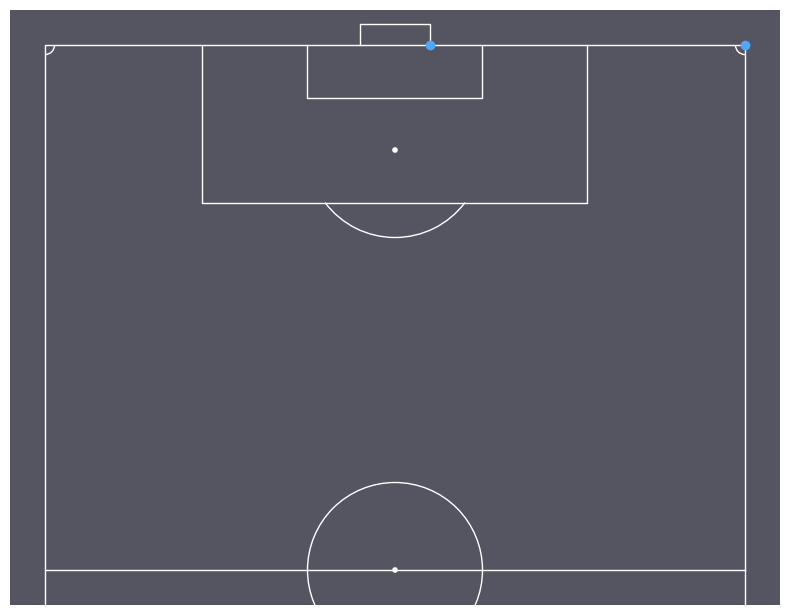

In [9]:

import pandas as pd
import numpy as np
import math
from mplsoccer import VerticalPitch, Pitch
width = 7.32
pitch = VerticalPitch(half=True, goal_type='box', corner_arcs=True, pitch_color='#545560', line_color='white', linewidth=1)

fig, ax = pitch.draw(figsize=(8,8))
sc = pitch.scatter(120, 44, 
                   ax=ax, color='#4da6ff', alpha=1.0, label='Shot')

sc = pitch.scatter(120, 80, 
                   ax=ax, color='#4da6ff', alpha=1.0, label='Shot')

def calculate_angle(x, y):
    from numpy import arctan2, sqrt
    new_x = 120 - x
    new_y = abs(y - 40)
    # The expression for tan(theta)
    tan_theta = (width * new_x) / (new_x**2 + new_y**2 - (width/2)**2)
    
    # Calculate theta using the arctan2 function to handle the correct quadrant
    theta = arctan2(tan_theta, sqrt(1 + tan_theta**2))
    
    return math.degrees(theta)

def calculate_dist (x ,y):
    dist = ((x - 120)**2 + (y -40)**2)**0.5
    return dist

# angles_goal = []
# angles_shot = []

# dist_goal = []
# dist_shot = []
# for i in range (len(x_goal_coordinates_damallsvenskan)):
#     angles_goal.append(calculate_angle(x_goal_coordinates_damallsvenskan_scaled[i], y_goal_coordinates_damallsvenskan_scaled[i]))

# for i in range(len(x_shot_coordinates_damallsvenskan_scaled)):
#     angles_shot.append(calculate_angle(x_shot_coordinates_damallsvenskan_scaled[i], y_shot_coordinates_damallsvenskan_scaled[i]))


# for i in range (len(x_goal_coordinates_damallsvenskan)):
#     dist_goal.append(calculate_dist(x_goal_coordinates_damallsvenskan_scaled[i], y_goal_coordinates_damallsvenskan_scaled[i]))

# for i in range(len(x_shot_coordinates_damallsvenskan_scaled)):
#     dist_goal.append(calculate_dist(x_shot_coordinates_damallsvenskan_scaled[i], y_shot_coordinates_damallsvenskan_scaled[i]))

for i in range( len (data)):
    shot = data[i]
    shot["distance"] = calculate_dist(shot['x'], shot['y'])

for i in range( len (data)):
    shot = data[i]
    shot["angle"] = calculate_angle(shot['x'], shot['y'])






## Logistic Regression

In [64]:

from sklearn import preprocessing


data = pd.DataFrame(data)

# Separating the features and the target variable 
X = data[['distance','angle']]
Y = data[['goal']]


regressor = LogisticRegression(random_state=0)
# Fit the regressor with x and y data
regressor.fit(X, Y)

xG_map = np.zeros((100,80))

for x in range(100):
    for y in range(80):
        arr = np.array([calculate_dist(x,y), calculate_angle(x,y)])
        reshaped_arr = arr.reshape(1, -1)
        xG_map[x][y] = regressor.predict(reshaped_arr)



/var/folders/cn/b4r618q142sb6srpvcxf2jlw0000gn/T/ipykernel_15101/16055454.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xG_map[x][y] = regressor.predict(reshaped_arr)
/var/folders/cn/b4r618q142sb6srpvcxf2jlw0000gn/T/ipykernel_15101/16055454.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xG_map[x][y] = regressor.predict(reshaped_arr)
/var/folders/cn/b4r618q142sb6srpvcxf2jlw0000gn/T/ipykernel_15101/16055454.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.2

## Categorical gradient boosting

In [59]:
from catboost import Pool, CatBoostRegressor

xg_cat_boost = np.zeros((100,80))

model = CatBoostRegressor(iterations=3, 
                          depth=2, 
                          learning_rate=1, 
                          loss_function='RMSE')

train_pool = Pool(X, 
                  Y)
model.fit(train_pool)

for x in range(100):
    for y in range(80):
        arr = np.array([calculate_dist(x,y), calculate_angle(x,y)])
        reshaped_arr = arr.reshape(1, -1)
        xg_cat_boost[x][y] = model.predict(reshaped_arr)

0:	learn: 0.3028502	total: 1.75ms	remaining: 3.51ms
1:	learn: 0.3017740	total: 2.88ms	remaining: 1.44ms
2:	learn: 0.2983239	total: 3.91ms	remaining: 0us


/var/folders/cn/b4r618q142sb6srpvcxf2jlw0000gn/T/ipykernel_15101/5323177.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xg_cat_boost[x][y] = model.predict(reshaped_arr)


## Bayesian regression

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model

reg = linear_model.BayesianRidge()
reg.fit(X, Y)
xG_bayesian = np.zeros((100,80))
for x in range(100):
    for y in range(80):
        arr = np.array([calculate_dist(x,y), calculate_angle(x,y)])
        reshaped_arr = arr.reshape(1, -1)
        xG_bayesian[x][y] = reg.predict(reshaped_arr)

/var/folders/cn/b4r618q142sb6srpvcxf2jlw0000gn/T/ipykernel_15101/3591836724.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xG_bayesian[x][y] = reg.predict(reshaped_arr)
/var/folders/cn/b4r618q142sb6srpvcxf2jlw0000gn/T/ipykernel_15101/3591836724.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xG_bayesian[x][y] = reg.predict(reshaped_arr)
/var/folders/cn/b4r618q142sb6srpvcxf2jlw0000gn/T/ipykernel_15101/3591836724.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

## Random forest

In [65]:
from sklearn.ensemble import RandomForestRegressor


regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X, Y)
xG_randomforest = np.zeros((100,80))
for x in range(100):
    for y in range(80):
        arr = np.array([calculate_dist(x,y), calculate_angle(x,y)])
        reshaped_arr = arr.reshape(1, -1)
        xG_randomforest[x][y] = regr.predict(reshaped_arr)


/var/folders/cn/b4r618q142sb6srpvcxf2jlw0000gn/T/ipykernel_15101/1388832163.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xG_randomforest[x][y] = regr.predict(reshaped_arr)
/var/folders/cn/b4r618q142sb6srpvcxf2jlw0000gn/T/ipykernel_15101/1388832163.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xG_randomforest[x][y] = regr.predict(reshaped_arr)
/var/folders/cn/b4r618q142sb6srpvcxf2jlw0000gn/T/ipykernel_15101/1388832163.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprec

## Plotting the heatmap for the xG

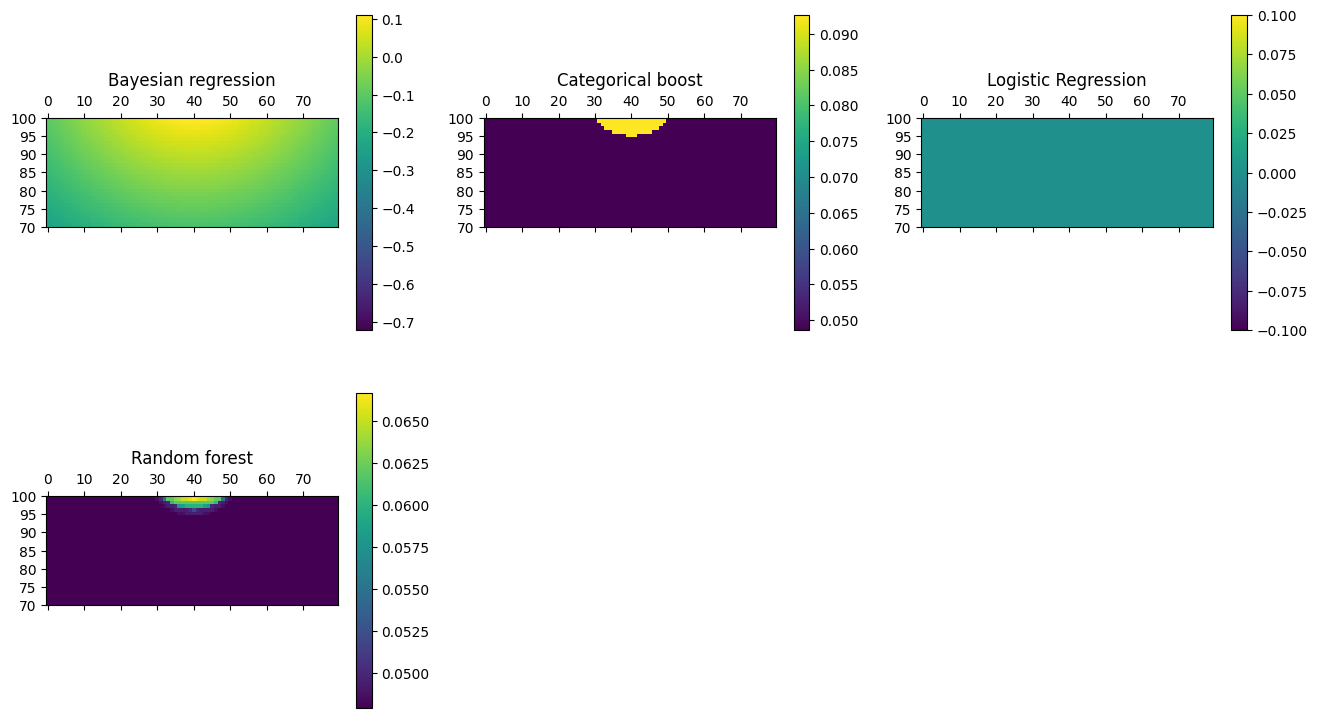

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# a 2D array with linearly increasing values on the diagonal

figure = plt.figure(figsize=(16,9))
axes = figure.add_subplot(2,3,1)
axes.set_title("Bayesian regression")
axes.set_ylim(bottom=70,top=100)
caxes = axes.matshow(xG_bayesian, interpolation ='nearest', )
figure.colorbar(caxes)


axes2 = figure.add_subplot(2,3,2)
axes2.set_title("Categorical boost")
axes2.set_ylim(bottom=70,top=100)

caxes2 = axes2.matshow(xg_cat_boost, interpolation ='nearest')
figure.colorbar(caxes2)

axes3 = figure.add_subplot(2,3,3)
axes3.set_title("Logistic Regression")
axes3.set_ylim(bottom=70,top=100)

caxes3 = axes3.matshow(xG_map, interpolation ='nearest')
figure.colorbar(caxes3)

axes4 = figure.add_subplot(2,3,4)
axes4.set_title("Random forest")
axes4.set_ylim(bottom=70,top=100)
caxes4 = axes4.matshow(xG_randomforest, interpolation ='nearest')
figure.colorbar(caxes4)
plt.show()





In [ ]:

# Evaluating the model
from sklearn.metrics import mean_squared_error, r2_score
 
# Access the OOB Score
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
 
# Making predictions on the same data or new data
predictions = regressor.predict(X)
 
# Evaluating the model
mse = mean_squared_error(y, predictions)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y, predictions)
print(f'R-squared: {r2}')

Out-of-Bag Score: 0.0251189436311402
Mean Squared Error: 0.08133839179774717
R-squared: 0.186577185953832
